In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy

In [18]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use('dark_background')

In [19]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i), qk=np.array(j))
            y=y+1
        y=0
        x=x+1
    return cohort_dist

def plot_KLD(cohort_dist,age_labels,name,vmax=1):
    # cohort_dist is matrix of
    seqmatcolor='Purples_r'
    cmg=sns.clustermap(cohort_dist,cmap=seqmatcolor,xticklabels=1,yticklabels=1,
                   colors_ratio=0.2,cbar_pos=(0.99, 0.045, 0.03, .70),
                   col_cluster=False,row_cluster=False,
                   method='average',metric='sqeuclidean', vmax=vmax)
    cmg.fig.set_size_inches(10,10)
    ax = cmg.ax_heatmap
    ax.set_xticklabels(age_labels)
    ax.set_yticklabels(age_labels)
    ax.set_title('Syllable Usage based KLD distance',fontsize=20)
    plt.show()

In [20]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/longtogeny_musages_mtx_all.parquet')
mdf_all = pd.read_parquet(path)
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/longtogeny_musages_mtx_most_used.parquet')
mdf = pd.read_parquet(path)

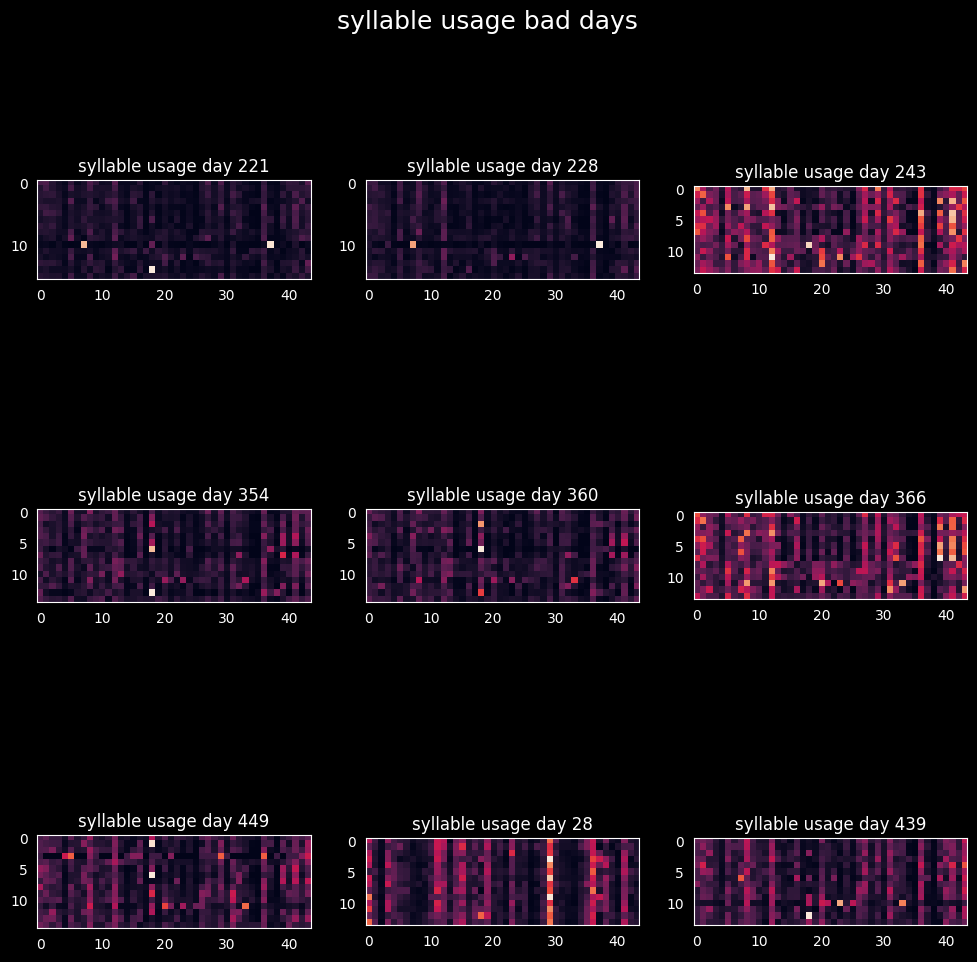

In [21]:
## filter out bad datapoints. 28 and 439 are not bad!! just for comparison
bad=[221, 228 ,243, 354, 360,366, 449, 28, 439]
# for males
plt.figure(figsize=(12, 12))
#plt.subplots_adjust(hspace=0.1)
plt.suptitle("syllable usage bad days", fontsize=18, y=0.95)
n=0
for day in bad:
    ax = plt.subplot(3, 3, n + 1)
    plt.imshow(mdf.loc[[day]])
    ax.set_title('syllable usage day '+str(day))
    n=n+1

In [22]:
## filter out bad days - 
bad_session=[221, 228]
#bad_syllable=[44,89]
bad_syllable=[44]
bad_mouse='04_01'
#temp = mdf.loc[~mdf.index.isin(list(bad))]
newdf= mdf.copy()
newdf.drop(bad_session, level=0, axis=0, inplace=True)
newdf.drop(bad_mouse, level=1, axis=0, inplace=True)
newdf.drop(bad_syllable, axis=1, inplace=True)

In [23]:
## kld calculations

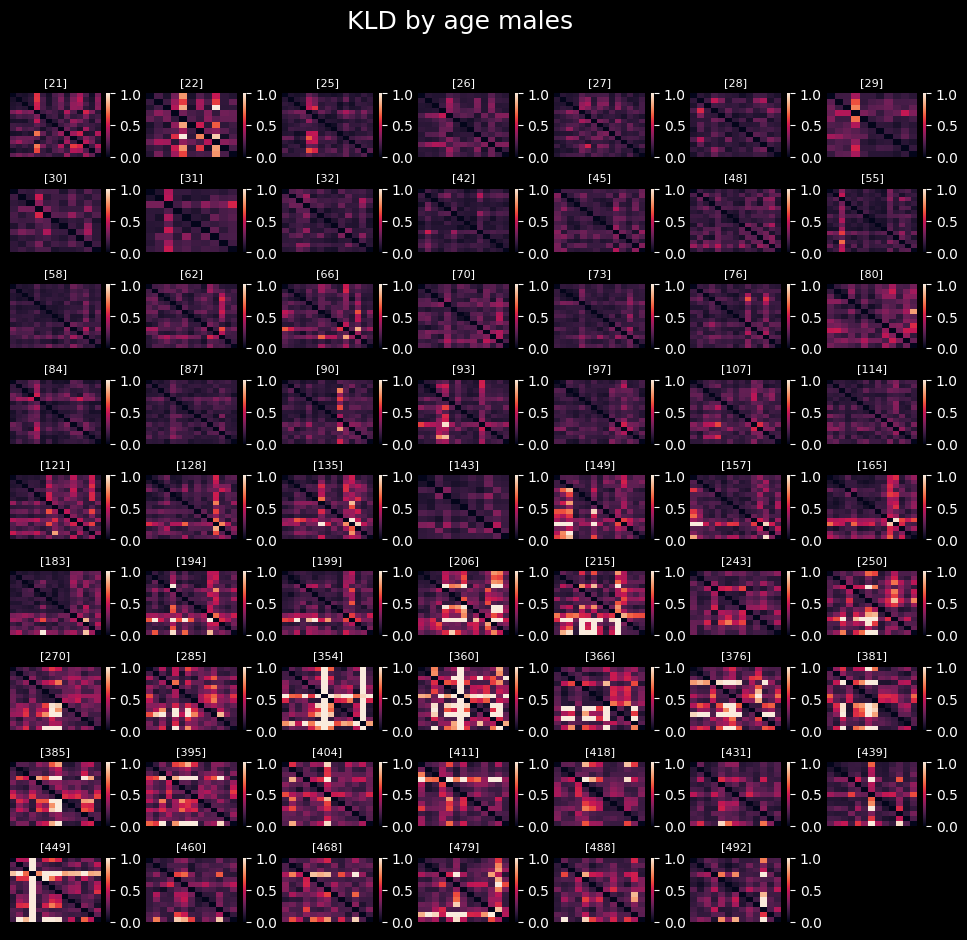

In [24]:
# for males
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("KLD by age males", fontsize=18, y=0.95)
to_plot=[]
n=0
ages=[]
kld=[]
exp=[]
mouse=[]
for age,_df in enumerate(newdf.groupby('age')):
    ages.extend(_df[1].index.get_level_values(0).to_numpy())
    mouse.extend(_df[1].index.get_level_values(1).to_numpy())
    #exp.extend(_df[1].index.get_level_values(2).to_numpy())
    exp.extend([1]*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = KLD_analysis(data_temp)
    kld.extend(np.mean(kld_temp, axis=1))
    to_plot.append(kld_temp)
    ax = plt.subplot(10, 7, n + 1)
    sns.heatmap(kld_temp,ax=ax, vmax=1.0)
    ax.set_title(str(_df[1].index.get_level_values(0).unique().to_numpy()), fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
    n=n+1

In [25]:
np.shape(to_plot[-1])

(13, 13)

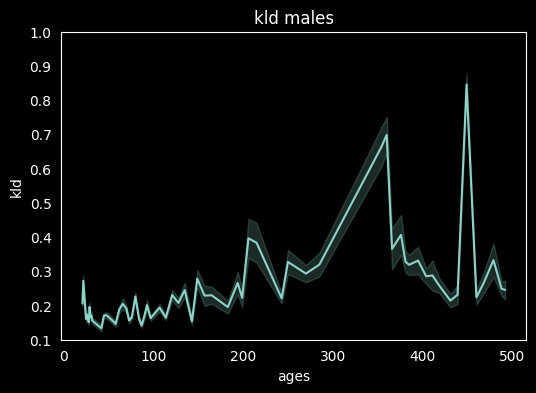

In [26]:
# plot kld values
df=pd.DataFrame()
df['ages']=ages
df['kld']=kld
df['Nmice']=exp
df['mouse']=mouse
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=df, x="ages", y="kld", estimator='mean', errorbar='se')
ax.set_title('kld males')
ax.set_ylim(0.10,1)
em = df.copy()

In [27]:
pd.set_option('display.max_rows', None)
df2=df.groupby('ages').agg({'kld':'mean','Nmice':'sum'})

<Axes: xlabel='ages', ylabel='kld'>

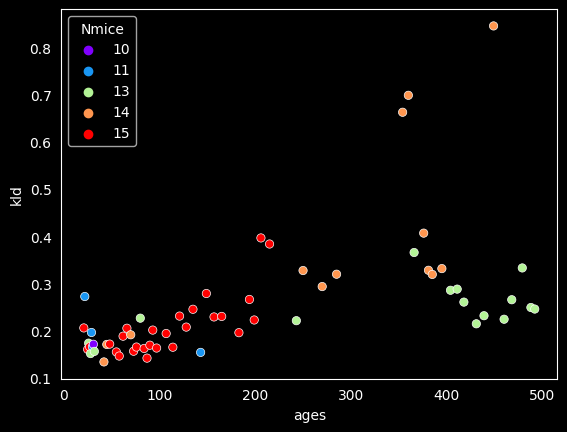

In [28]:
sns.scatterplot(data=df2, x="ages", y="kld", hue='Nmice', palette = 'rainbow')

In [29]:
## smooth kld

In [30]:
from scipy.ndimage.filters import gaussian_filter1d

In [31]:
# prepare data
data=df.copy()
ind = data['ages'].unique()
concat = pd.DataFrame()
for m, _df in data.groupby('mouse'):
    #_df=_df.drop_duplicates(subset=['ages'])
    temp= gaussian_filter1d(_df['kld'], sigma=3)
    _df['kld'] = temp
    concat=pd.concat([concat,_df])

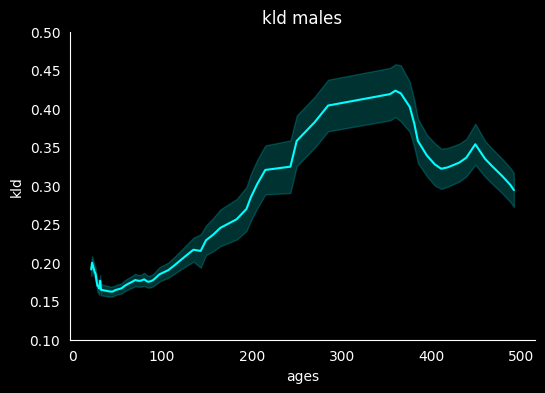

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=concat, x="ages", y="kld", estimator='mean', errorbar='se', color='cyan')
ax.set_title('kld males')
ax.set_ylim(0.1,0.5)
em = df.copy()
sns.despine()
plt.savefig(data_loc +'long_kld_indv.pdf', bbox_inches='tight')

In [ ]:
## create a movie

In [10]:
age_labels=np.unique(ages)

Moviepy - Building video /n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana/figs/kld_long.mp4.
Moviepy - Writing video /n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana/figs/kld_long.mp4



Moviepy - Done !
Moviepy - video ready /n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana/figs/kld_long.mp4


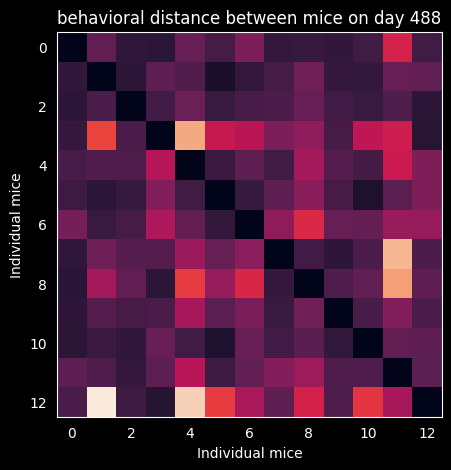

In [35]:
# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython import display
 
# numpy array
#x = np.linspace(-2, 2, 200)
 
# duration of the video
fps=5
duration = int(np.floor(len(to_plot)/fps))
 
# matplot subplot
plt.style.use("dark_background") 
fig, ax = plt.subplots()
fig.set_size_inches(5,5) 
# method to get frames
i=0
def make_frame(t):
    global i
    global ind
    # clear
    ax.clear()
    # plotting line
    data_temp=to_plot[i]
    #sns.heatmap(data_temp,ax=ax, vmax=1.0)
    im=ax.imshow(data_temp, vmax=1.0)
    ax.set_title('behavioral distance between mice on day ' +str(age_labels[i]),fontsize = 12)
    ax.set_xlabel('Individual mice')
    ax.set_ylabel('Individual mice')
    #fig.colorbar(im)
    i=i+1
    # returning numpy image
    return mplfig_to_npimage(fig)
 
# creating animation
animation = VideoClip(make_frame, duration = duration)
animation.write_videofile(data_loc+"kld_long.mp4",fps=fps)
# displaying animation with auto play and looping
#animation.ipython_display(fps = fps, loop = False, autoplay = False)


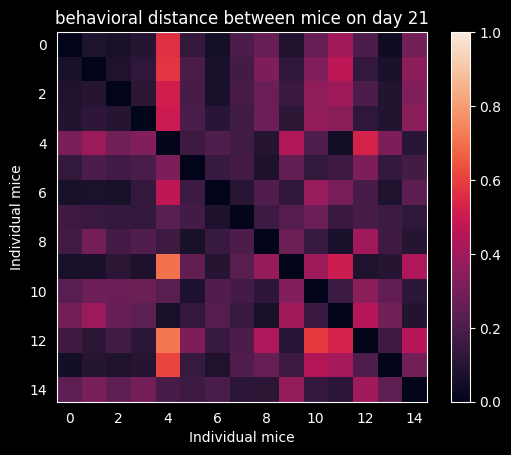

In [32]:
data_temp=to_plot[0]
fig, ax = plt.subplots()
#sns.heatmap(data_temp,ax=ax, vmax=1.0)
im=ax.imshow(data_temp, vmax=1.0)
ax.set_title('behavioral distance between mice on day ' +str(age_labels[0]),fontsize = 12)
ax.set_xlabel('Individual mice')
ax.set_ylabel('Individual mice')
fig.colorbar(im)
i=i+1